# Convolutional Neural Network Example

Build a convolutional neural network with TensorFlow v2.

This example is using a low-level approach to better understand all mechanics behind building convolutional neural networks and the training process.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32 and normalized to [0, 1].

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [2]:
# Copyright 2020 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""AdaBelief for TensorFlow.
Modified from tensorflow/tensorflow/python/keras/optimizer_v2/adam.py
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import training_ops
from tensorflow.python.util.tf_export import keras_export


@keras_export('keras.optimizers.AdaBeliefOptimizer')
class AdaBeliefOptimizer(optimizer_v2.OptimizerV2):
    """Optimizer that implements the AdaBelief algorithm.
    References:
    AdaBelief Optimizer: Adapting Stepsizes by the Belief in Observed Gradients:
      ([pdf](https://arxiv.org/pdf/2010.07468.pdf))
    """

    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-7,
               amsgrad=False,
               name="AdaBelief",
               **kwargs):
        """Construct a new Adam optimizer.
        Args:
          learning_rate: A Tensor or a floating point value.  The learning rate.
          beta_1: A float value or a constant float tensor. The exponential decay
            rate for the 1st moment estimates.
          beta_2: A float value or a constant float tensor. The exponential decay
            rate for the 2nd moment estimates.
          epsilon: A small constant for numerical stability.
          amsgrad: Boolean. Whether to apply AMSGrad variant of this algorithm from
            the paper "On the Convergence of Adam and beyond". Defaults to `False`.
          name: Optional name for the operations created when applying gradients.
            Defaults to "Adam".
          **kwargs: Keyword arguments. Allowed to be one of
            `"clipnorm"` or `"clipvalue"`.
            `"clipnorm"` (float) clips gradients by norm; `"clipvalue"` (float) clips
            gradients by value.
        """
        super(AdaBeliefOptimizer, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self.epsilon = epsilon or backend_config.epsilon()
        self.amsgrad = amsgrad
        
    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 's')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'shat')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdaBeliefOptimizer, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)
        lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
             (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdaBeliefOptimizer, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values,
                                use_locking=self._use_locking)
  
        # s_t = beta2 * s + (1 - beta2) * (g_t - m_t) * (g_t - m_t)
        s = self.get_slot(var, 's')
        s_scaled_g_values = (grad - m_t) * (grad - m_t) * coefficients['one_minus_beta_2_t']
        s_t = state_ops.assign(s, s * coefficients['beta_2_t'] + s_scaled_g_values + coefficients['epsilon'],
                                use_locking=self._use_locking)

        if not self.amsgrad:
            s_sqrt = math_ops.sqrt(s_t)
            var_update = state_ops.assign_sub(
                var, coefficients['lr'] * m_t / (s_sqrt + coefficients['epsilon']),
                use_locking=self._use_locking)
            return control_flow_ops.group(*[var_update, m_t, s_t])
        else:
            s_hat = self.get_slot(var, 'shat')
            s_hat_t = math_ops.maximum(s_hat, s_t)
            with ops.control_dependencies([s_hat_t]):
                s_hat_t = state_ops.assign(s_hat, s_hat_t, use_locking=self._use_locking)
            s_hat_sqrt = math_ops.sqrt(s_hat_t)
            var_update = state_ops.assign_sub(
                var,
                coefficients['lr'] * m_t / (s_hat_sqrt + coefficients['epsilon']),
                use_locking=self._use_locking)
            return control_flow_ops.group(*[var_update, m_t, s_t, s_hat_t])

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                                use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # s_t = beta2 * s + (1 - beta2) * (g_t - m_t) * (g_t - m_t)
        s = self.get_slot(var, 's')
        m_t_indices = array_ops.gather(m_t, indices)
        s_scaled_g_values = (grad - m_t_indices) * (grad - m_t_indices) * coefficients['one_minus_beta_2_t']
        s_t = state_ops.assign(s, s * coefficients['beta_2_t'],
                                use_locking=self._use_locking)
        with ops.control_dependencies([s_t]):
            s_t = self._resource_scatter_add(s, indices, s_scaled_g_values + coefficients['epsilon'])

        if not self.amsgrad:
            s_sqrt = math_ops.sqrt(s_t)
            var_update = state_ops.assign_sub(
                var, coefficients['lr'] * m_t / (s_sqrt + coefficients['epsilon']),
                use_locking=self._use_locking)
            return control_flow_ops.group(*[var_update, m_t, s_t])
        else:
            s_hat = self.get_slot(var, 'shat')
            s_hat_t = math_ops.maximum(s_hat, s_t)
            with ops.control_dependencies([s_hat_t]):
                s_hat_t = state_ops.assign(s_hat, s_hat_t, use_locking=self._use_locking)
            s_hat_sqrt = math_ops.sqrt(s_hat_t)
            var_update = state_ops.assign_sub(
                var,
                coefficients['lr'] * m_t / (s_hat_sqrt + coefficients['epsilon']),
                use_locking=self._use_locking)
            return control_flow_ops.group(*[var_update, m_t, s_t, s_hat_t])

    def get_config(self):
        config = super(AdaBeliefOptimizer, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
        })
        return config

In [3]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [4]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [5]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [7]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Stochastic gradient descent optimizer.
optimizer = AdaBeliefOptimizer(learning_rate, epsilon=1e-14) # Deafault epsilon for Adam is 1e-7 in tensorlfow, 1e-8 in pytorch
#optimizer = tf.optimizers.Adam(learning_rate)

In [8]:
# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [9]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 10, loss: 1.821625, accuracy: 0.765625
step: 20, loss: 1.651432, accuracy: 0.843750
step: 30, loss: 1.585248, accuracy: 0.945312
step: 40, loss: 1.568779, accuracy: 0.945312
step: 50, loss: 1.532894, accuracy: 0.953125
step: 60, loss: 1.533999, accuracy: 0.976562
step: 70, loss: 1.543239, accuracy: 0.945312
step: 80, loss: 1.515152, accuracy: 0.968750
step: 90, loss: 1.509951, accuracy: 0.976562
step: 100, loss: 1.529341, accuracy: 0.953125
step: 110, loss: 1.492579, accuracy: 0.984375
step: 120, loss: 1.494740, accuracy: 0.984375
step: 130, loss: 1.509750, accuracy: 0.968750
step: 140, loss: 1.479277, accuracy: 1.000000
step: 150, loss: 1.486714, accuracy: 0.984375
step: 160, loss: 1.484489, accuracy: 0.984375
step: 170, loss: 1.519642, accuracy: 0.960938
step: 180, loss: 1.495328, accuracy: 0.992188
step: 190, loss: 1.509227, accuracy: 0.953125
step: 200, loss: 1.491168, accuracy: 0.992188


In [10]:
# Test model on validation set.
pred = conv_net(x_test)
print("Test Accuracy: {}" .format( accuracy(pred, y_test)) )

Test Accuracy: 0.9768000245094299


In [44]:
# Visualize predictions.
import matplotlib.pyplot as plt

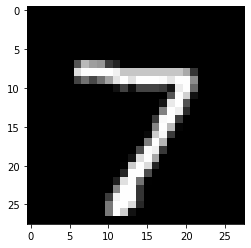

Model prediction: 7


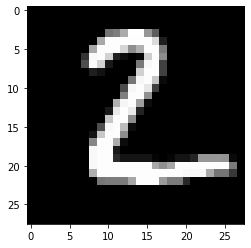

Model prediction: 2


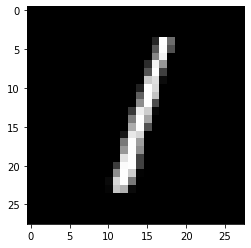

Model prediction: 1


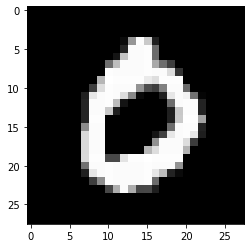

Model prediction: 0


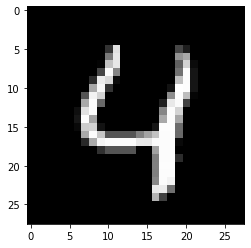

Model prediction: 4


In [45]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = conv_net(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))